In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DATA TA.xlsx to DATA TA.xlsx


In [ ]:
#install packages
!pip install impyute
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 36.0 MB/s 
     |████████████████████████████████| 9.5 MB 64.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import impyute as impy
import time 
import openpyxl
from pandas import DataFrame
from scipy import stats
from pmdarima.utils import diff_inv
from matplotlib import pyplot
from numpy import hstack
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers import Dense 
from keras.layers import Dropout
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
#import data
dataaa = pd.read_excel('DATA TA.xlsx', sheet_name='cleaned')

# Time Series Plot Before Imputation

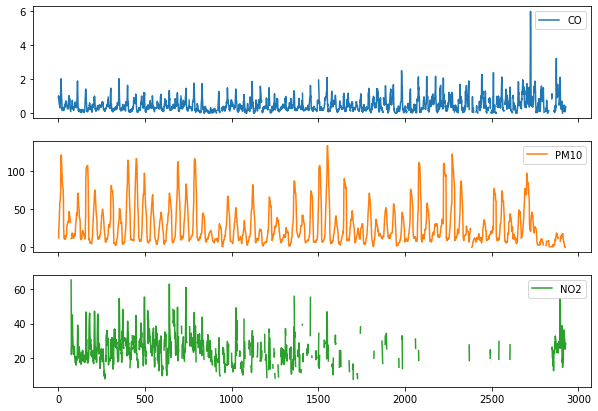

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(10,7), sharex=True)
dataaa.plot(subplots=True, ax=axes)
plt.savefig('ts plot.png')

# Import Imputed Data

In [ ]:
#import data
dataa = pd.read_excel('DATA TA.xlsx', sheet_name='imputed2')

# Time Series Plot After EM Imputation

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(10,7), sharex=True)
dataa.plot(subplots=True, ax=axes)
plt.savefig('ts plot1.png')

NameError: ignored

# Descriptive Statistics and Correlation Analysis

In [ ]:
dataa.describe()

,CO,PM10,NO2
count,1776.000000,1776.000000,1776.000000
mean,0.413344,30.091104,24.057527
std,0.311286,26.676928,7.147503
min,0.001350,1.000000,5.868400
25%,0.202050,10.276750,20.703727
50%,0.329730,20.000000,22.970715
75%,0.531927,41.110750,26.800780
max,2.107100,133.000000,65.551000


In [ ]:
pvalue = stats.pearsonr(dataa.CO, dataa.PM10)
pvalue

(0.26684901110173675, 2.4633097743037514e-30)

In [ ]:
pvalue2 = stats.pearsonr(dataa.CO, dataa.NO2)
pvalue2

(0.4603239351414996, 7.620572007914823e-94)

In [ ]:
pvalue3 = stats.pearsonr(dataa.PM10, dataa.NO2)
pvalue3

(0.165401482373371, 2.317565418013142e-12)

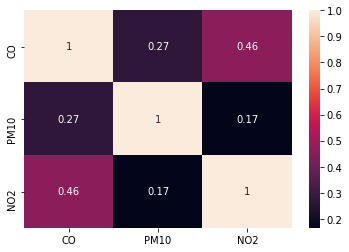

In [ ]:
corrMatrix = dataa.corr()
sns.heatmap(corrMatrix, annot=True)
plt.savefig('corrplot.png')

# Import Transformed Data

In [ ]:
#import data
data = pd.read_excel('DATA TA.xlsx', sheet_name='LSTM')
data

,CO,PM10,NO2
0,0.935500,1.823517,5.243588
1,1.008514,1.873975,5.358315
2,0.951183,2.124087,5.279095
3,0.850476,2.171428,5.134267
4,0.773240,2.333245,5.040015
...,...,...,...
2923,0.074820,1.000000,26.814000
2924,0.115720,0.066660,24.931000
2925,0.176630,26.366590,25.906000
2926,0.277060,27.587950,27.982000


# Split Data into Data Training dan Data Testing

In [ ]:
#Split data into data training and data testing
data2 = data.loc[:,['CO', 'PM10', 'NO2']]
datat = data2[:1440]
datadiff1 = datat.diff(periods=1)
data_train = datadiff1.diff(periods=48)

data_test = data2[1440:]
data_test = data_test.reset_index().iloc[:,1:4] 
data_trainCO, data_trainPM10, data_trainNO2 = data_train.iloc[:,0:1], data_train.iloc[:,1:2], data_train.iloc[:,2:3]
data_testactual = data_test
data_testactual

,CO,PM10,NO2
0,0.45886,10.00000,23.28000
1,0.43054,9.72500,23.70707
2,0.28981,9.00000,27.39900
3,0.27823,9.60000,22.41842
4,0.19367,11.00000,21.71917
...,...,...,...
1483,0.07482,1.00000,26.81400
1484,0.11572,0.06666,24.93100
1485,0.17663,26.36659,25.90600
1486,0.27706,27.58795,27.98200


# Normalisasi Data

In [ ]:
scCO = MinMaxScaler(feature_range = (0, 1))
scPM10 = MinMaxScaler(feature_range = (0, 1))
scNO2 = MinMaxScaler(feature_range = (0, 1))
data_trainCO = scCO.fit_transform(data_trainCO)
data_trainPM10 = scPM10.fit_transform(data_trainPM10)
data_trainNO2 = scNO2.fit_transform(data_trainNO2)

In [ ]:
n_timestep = [1,2,3,4,5,48,49,50,51,52,53,54,96,97,98,99,100,101,102]
data_trainGabung = hstack((data_trainCO, data_trainPM10, data_trainNO2)) 

# Struktur Data Training Multivariate CO
x_trainMulti = []
CO_trainMulti = []
for i in range(len(n_timestep), len(data_trainGabung)): 
  x_trainMulti.append(data_trainGabung[(i-len(n_timestep)):i])
  CO_trainMulti.append(data_trainCO[i,0])
x_trainMulti, CO_trainMulti = np.array(x_trainMulti), np.array(CO_trainMulti)
CO_trainMulti = np.reshape(CO_trainMulti, (CO_trainMulti.shape[0]))

# Struktur Data Training Multivariate PM10
x_trainMulti2 = []
PM10_trainMulti = []
for i in range(len(n_timestep), len(data_trainGabung)): 
   x_trainMulti2.append(data_trainGabung[(i-len(n_timestep)):i]) 
   PM10_trainMulti.append(data_trainPM10[i,0])
x_trainMulti2, PM10_trainMulti = np.array(x_trainMulti2), np.array(PM10_trainMulti)
PM10_trainMulti = np.reshape(PM10_trainMulti, (PM10_trainMulti.shape[0]))

# Struktur Data Training Multivariate NO2
x_trainMulti3 = []
NO2_trainMulti = []
for i in range(len(n_timestep), len(data_trainGabung)): 
   x_trainMulti3.append(data_trainGabung[(i-len(n_timestep)):i]) 
   NO2_trainMulti.append(data_trainNO2[i,0]) 
x_trainMulti3, NO2_trainMulti = np.array(x_trainMulti3), np.array(NO2_trainMulti)
NO2_trainMulti = np.reshape(NO2_trainMulti, (NO2_trainMulti.shape[0]))
CO_trainMulti

array([       nan,        nan,        nan, ..., 0.54511731, 0.56208412,
       0.53491933])

In [ ]:
# Struktur Data Test Multivariate untuk Prediksi
inputs_multi = data2[len(data2) - len(data_test) - len(n_timestep):].values
inputs_multi = pd.DataFrame(inputs_multi) 
inputs_multi.columns = ['CO', 'PM10', 'NO2']
data_testCO, data_testPM10, data_testNO2 = inputs_multi.iloc[:,2:3], inputs_multi.iloc[:,1:2], inputs_multi.iloc[:,0:1]
data_testCO = scCO.fit_transform(data_testCO)
data_testPM10 = scPM10.fit_transform(data_testPM10)
data_testNO2 = scNO2.fit_transform(data_testNO2)
data_testGabung = hstack((data_testCO, data_testPM10, data_testNO2))

x_testMulti = []
for i in range(len(n_timestep), len(inputs_multi)):  
    x_testMulti.append(data_testGabung[i-len(n_timestep):i, : ])
x_testMulti = np.array(x_testMulti)
x_testMulti = x_testMulti.reshape((x_testMulti.shape[0], x_testMulti.shape[1],3))

# Build Model

In [ ]:
n_DenseUnits = 1
n_loss = 'mean_squared_error' 
n_LSTMunits = [1] #,2,3,4,5]
n_DropoutRate = [0.1] #, 0.3, 0.5, 0.7]
n_optimizer = ['Adam'] 
n_epoch = [50] #50 
n_batchsize = [48]

for h in range(len(n_timestep)):
  for i in range(len(n_LSTMunits)):
      for j in range(len(n_DropoutRate)):
          for k in range(len(n_optimizer)):
              for l in range(len(n_epoch)):
                  for m in range(len(n_batchsize)):
                    
                    # Build Multivariate LSTM for CO
                    modelMulti = Sequential()
                    np.random.seed(7)
                    modelMulti.add(LSTM(units = n_LSTMunits[i], input_shape = (x_trainMulti.shape[1], x_trainMulti.shape[2]))) 
                    modelMulti.add(Dropout(rate = n_DropoutRate[j]))
                    modelMulti.add(Dense(units = n_DenseUnits))
                    modelMulti.compile(optimizer = n_optimizer[k], loss = n_loss)
                    model_fit = modelMulti.fit(x_trainMulti[49:], CO_trainMulti[49:])
                    print(model_fit)
                    
                    for layer in modelMulti.layers:
                      e = layer.get_config()
                      f = layer.get_weights()
                      print(e)
                      print(f)
                    
                    #predict for data training
                    CO_trainingMulti = modelMulti.predict(x_trainMulti)
                    data_trainPredCO = scCO.inverse_transform(CO_trainingMulti)
                    pred_CO = model_fit.forecast()
                    data_testPredCO = scCO.inverse_transform(pred_CO)

                    #predict for data testing
                    #CO_testMulti = modelMulti.predict(x_testMulti)
                    #data_testPredCO = scCO.inverse_transform(CO_testMulti)
                    #df = pd.DataFrame(data_trainPredCO)
                    #df.columns = ['CO']

                    #Undifferencing 48                  
                    #def inv_diff (df_orig, df_diff, periods):
                      #value = np.array(df_orig[:periods].tolist()+df_diff[periods:].tolist())

                    # Generate np.array with inverse diff
                      #inv_diff_vals = diff_inv(value, periods,1 )[periods:]
                      #return inv_diff_vals
                    #un48 = inv_diff(datadiff1.CO, df.CO, 48)

                    #un_48 = pd.DataFrame(un48)
                    #un_48 = un_48.fillna(datadiff1['CO'][i])
                    #df2 = pd.DataFrame(un_48)
                    #df2.columns = ['CO']

                    #un48t = inv_diff(datadiff1.CO, CO_trainMulti, 48)
                    #un_48t = pd.DataFrame(un48t)
                    #un_48t = un_48t.fillna(datadiff1['CO'])
                    #df2t = pd.DataFrame(un_48t)
                    #df2t.columns = ['CO']
                    
                    #un_1 = df2.cumsum()
                    #un_1 = un_1.replace(np.nan, datat['CO']) 
                    #df3 = pd.DataFrame(un_1)

                    #un_1t = df2t.cumsum()
                    #un_1t = un_1t.replace(np.nan, datat['CO']) 
                    #df3t = pd.DataFrame(un_1t)

                    #untransfrom
                    #unt = (df3)**2
                    #unt_a = (df3t)**2
                    #un_test = (data_testPredCO)**2
                    #n_test1 = (data_test['CO'])**2

                    def rmse(z_truet, z_predt): 
                      z_truet, z_predt = np.array(z_truet), np.array(z_predt)
                      return np.sqrt(np.mean(((z_truet - z_predt) ** 2)))
                    RMSEt = '%.4f' % rmse(CO_trainMulti[49:], data_trainPredCO[49:])

                    def rmse(z_true, z_pred): 
                      z_true, z_pred = np.array(z_true), np.array(z_pred)
                      return np.sqrt(np.mean(((z_true - z_pred) ** 2)))
                    RMSE = '%.4f' % rmse(data_test['CO'], data_testPredCO)

                    #figPredict = plt.gcf()
                    plt.plot(CO_trainMulti[49:], color = 'red', label = 'Actual Train CO', linewidth=0.75)
                    plt.plot(data_trainPredCO[49:], color = 'blue', label = 'Predicted Train CO', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    #plt.savefig("/content/drive/My Drive/TA/co train/" +str(RMSEt)+ ' CO Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png')

                    #figPredict = plt.gcf()
                    plt.plot(data_test['CO'], color = 'red', label = 'Actual Test CO', linewidth=0.75)
                    plt.plot(data_testPredCO, color = 'blue', label = 'Predicted Test CO', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    #plt.savefig("/content/drive/My Drive/TA/co test/" +str(RMSE)+ ' CO Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png') 

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multit = np.hstack([data_trainPredCO])
                    A_PredictionResult_Multit = np.around(A_PredictionResult_Multit, decimals=4, out=None)
                    A_PredictionResult_Multit = A_PredictionResult_Multit.astype(str)  

                    A_EvaluationResult_Multit = [[RMSEt]]
                    A_EvaluationResult_Multit = np.asarray(A_EvaluationResult_Multit)

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multi = np.hstack([data_testPredCO])
                    A_PredictionResult_Multi = np.around(A_PredictionResult_Multi, decimals=4, out=None)
                    A_PredictionResult_Multi = A_PredictionResult_Multi.astype(str)  

                    A_EvaluationResult_Multi = [[RMSE]]
                    A_EvaluationResult_Multi = np.asarray(A_EvaluationResult_Multi)
                     
                    print("\n=================================\nRECAP RESULT (RMSE)\n=================================\n")
                    print(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
                              +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size\n')
                   
                    print("RMSE Training:")
                    print(RMSEt+ "\n" )
                    print("RMSE Testing:")
                    print(RMSE+ "\n" )

                    A_AnExcelResult_Multit = np.concatenate((A_EvaluationResult_Multit, A_PredictionResult_Multit), axis=0)
                    A_AnExcelResult_Multit = pd.DataFrame(A_AnExcelResult_Multit)
                    A_AnExcelResult_Multit.columns = ['Multivariate'] 
                    A_AnExcelResult_Multit.Multivariate = A_AnExcelResult_Multit.Multivariate.str.replace('.', ',') 
                    #A_AnExcelResult_Multit.to_excel("/content/drive/My Drive/TA/co train/" +str(RMSEt)+ ' CO Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False) 
 
                    A_AnExcelResult_Multi = np.concatenate((A_EvaluationResult_Multi, A_PredictionResult_Multi), axis=0)
                    A_AnExcelResult_Multi = pd.DataFrame(A_AnExcelResult_Multi)
                    A_AnExcelResult_Multi.columns = ['Multivariate'] 
                    A_AnExcelResult_Multi.Multivariate = A_AnExcelResult_Multi.Multivariate.str.replace('.', ',') 
                    #A_AnExcelResult_Multi.to_excel("/content/drive/My Drive/TA/co test/" +str(RMSE)+ ' CO Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False)

43/43 [==============================] - 2s 7ms/step - loss: 0.2307
{'name': 'lstm_393', 'trainable': True, 'batch_input_shape': (None, 19, 3), 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 1, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2}
[array([[-0.79604226, -0.16745955, -0.5143568 ,  0.6551205 ],
       [-0.70146227,  0.07060033,  0.

AttributeError: ignored

In [ ]:
n_DenseUnits = 1
n_loss = 'mean_squared_error' 
n_LSTMunits = [1, 2, 3, 4, 5]
n_DropoutRate = [0.1, 0.3, 0.5, 0.7]
n_optimizer = ['Adam'] 
n_epoch = [50] #50 
n_batchsize = [48]

for h in range(len(n_timestep)):
  for i in range(len(n_LSTMunits)):
      for j in range(len(n_DropoutRate)):
          for k in range(len(n_optimizer)):
              for l in range(len(n_epoch)):
                  for m in range(len(n_batchsize)):
                    
                    # Build Multivariate LSTM for PM10
                    modelMulti2 = Sequential()
                    modelMulti2.add(LSTM(units = n_LSTMunits[i], input_shape = (x_trainMulti2.shape[1], x_trainMulti2.shape[2]))) 
                    modelMulti2.add(Dropout(rate = n_DropoutRate[j]))
                    modelMulti2.add(Dense(units = n_DenseUnits))
                    modelMulti2.compile(optimizer = n_optimizer[k], loss = n_loss)

                    for layer in modelMulti2.layers:
                      n = layer.get_config()
                      o = layer.get_weights()
                      print(n)
                      print(o)

                    #for data training
                    PM10_trainingMulti = modelMulti2.predict(x_trainMulti2)
                    data_trainPredPM10 = scPM10.inverse_transform(PM10_trainingMulti)
                    #for data testing
                    PM10_testMulti = modelMulti2.predict(x_testMulti)
                    data_testPredPM10 = scPM10.inverse_transform(PM10_testMulti)
                    #df_PM10 = pd.DataFrame(data_trainPredPM10)
                    #df_PM10.columns = ['PM10']

                    #Undifferencing 48                  
                    #def inv_diff (df_orig, df_diff, periods):
                      #value = np.array(df_orig[:periods].tolist()+df_diff[periods:].tolist())

                      # Generate np.array with inverse diff
                      #inv_diff_vals = diff_inv(value, periods,1 )[periods:]
                      #return inv_diff_vals
                    #un48_PM10 = inv_diff(datadiff1.PM10, df_PM10.PM10, 48)
                    #un_48_PM10 = pd.DataFrame(un48_PM10)
                    #df2_PM10 = pd.DataFrame(un_48_PM10)
                    #df2_PM10.columns = ['PM10']

                    #un48t_PM10 = inv_diff(datadiff1.PM10, PM10_trainMulti, 48)
                    #un_48t_PM10 = pd.DataFrame(un48t_PM10)
                    #df2t_PM10 = pd.DataFrame(un_48t_PM10)
                    #df2t_PM10.columns = ['PM10']
                    
                    #un1_PM10 = inv_diff(datat.PM10, df2_PM10.PM10, 1)
                    #un_1_PM10 = pd.DataFrame(un1_PM10)
                    #un_1_PM10 = un_1_PM10.fillna(datat.PM10[i])
                    #df3_PM10 = pd.DataFrame(un_1_PM10)
                    #df3_PM10.columns = ['PM10']

                    #un1t_PM10 = inv_diff(datat.PM10, df2t_PM10.PM10, 1)
                    #un_1t_PM10 = pd.DataFrame(un1t_PM10)
                    #un_1t_PM10 = un_1t_PM10.fillna(datat.PM10[i])
                    #df3t_PM10 = pd.DataFrame(un_1t_PM10)
                    #df3t_PM10.columns = ['PM10']

                    #untransfrom
                    #unt_PM10 = (df3_PM10)**2
                    #unt_a_PM10 = (df3t_PM10)**2
                    #un_test_PM10 = (data_testPredPM10)**2
                    #un_test1_PM10 = (data_test['PM10'])**2

                    def rmse(z_truet, z_predt): 
                      z_truet, z_predt = np.array(z_truet), np.array(z_predt)
                      return np.sqrt(np.mean(((z_truet - z_predt) ** 2)))
                    RMSEt2 = '%.4f' % rmse(PM10_trainMulti[49:], data_trainPredPM10[49:])

                    def rmse(z_true, z_pred): 
                      z_true, z_pred = np.array(z_true), np.array(z_pred)
                      return np.sqrt(np.mean(((z_true - z_pred) ** 2)))
                    RMSE2 = '%.4f' % rmse(data_test['PM10'], data_testPredPM10)

                    #figPredict = plt.gcf()
                    plt.plot(PM10_trainMulti[49:], color = 'red', label = 'Actual Train PM10', linewidth=0.75)
                    plt.plot(data_trainPredPM10[49:], color = 'blue', label = 'Predicted Train PM10', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    plt.savefig("/content/drive/My Drive/TA/pm10 train/" +str(RMSEt2)+ ' PM10 Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png')

                    #figPredict = plt.gcf()
                    plt.plot(data_test['PM10'], color = 'red', label = 'Actual Test PM10', linewidth=0.75)
                    plt.plot(data_testPredPM10, color = 'blue', label = 'Predicted Test PM10', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    plt.savefig("/content/drive/My Drive/TA/pm10 test/" +str(RMSE2)+ ' PM10 Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png') 

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multit2 = np.hstack([data_trainPredPM10])
                    A_PredictionResult_Multit2 = np.around(A_PredictionResult_Multit2, decimals=4, out=None)
                    A_PredictionResult_Multit2 = A_PredictionResult_Multit2.astype(str)  

                    A_EvaluationResult_Multit2 = [[RMSEt2]]
                    A_EvaluationResult_Multit2 = np.asarray(A_EvaluationResult_Multit2)

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multi2 = np.hstack([data_testPredPM10])
                    A_PredictionResult_Multi2 = np.around(A_PredictionResult_Multi2, decimals=4, out=None)
                    A_PredictionResult_Multi2 = A_PredictionResult_Multi2.astype(str)  

                    A_EvaluationResult_Multi2 = [[RMSE2]]
                    A_EvaluationResult_Multi2 = np.asarray(A_EvaluationResult_Multi2)
                     
                    print("\n=================================\nRECAP RESULT (RMSE)\n=================================\n")
                    print(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
                              +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size\n')
                   
                    print("RMSE Training:")
                    print(RMSEt2+ "\n" )
                    print("RMSE Testing:")
                    print(RMSE2+ "\n" )

                    A_AnExcelResult_Multit2 = np.concatenate((A_EvaluationResult_Multit2, A_PredictionResult_Multit2), axis=0)
                    A_AnExcelResult_Multit2 = pd.DataFrame(A_AnExcelResult_Multit2)
                    A_AnExcelResult_Multit2.columns = ['Multivariate'] 
                    A_AnExcelResult_Multit2.Multivariate = A_AnExcelResult_Multit2.Multivariate.str.replace('.', ',') 
                    A_AnExcelResult_Multit2.to_excel("/content/drive/My Drive/TA/pm10 train/" +str(RMSEt2)+ ' PM10 Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False) 
 
                    A_AnExcelResult_Multi2 = np.concatenate((A_EvaluationResult_Multi2, A_PredictionResult_Multi2), axis=0)
                    A_AnExcelResult_Multi2 = pd.DataFrame(A_AnExcelResult_Multi2)
                    A_AnExcelResult_Multi2.columns = ['Multivariate'] 
                    A_AnExcelResult_Multi2.Multivariate = A_AnExcelResult_Multi2.Multivariate.str.replace('.', ',') 
                    A_AnExcelResult_Multi2.to_excel("/content/drive/My Drive/TA/pm10 test/" +str(RMSE2)+ ' PM10 Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False)

In [ ]:
n_DenseUnits = 1
n_loss = 'mean_squared_error' 
n_LSTMunits = [1, 2, 3, 4, 5]
n_DropoutRate = [0.1, 0.3, 0.5, 0.7]
n_optimizer = ['Adam'] 
n_epoch = [50] #50 
n_batchsize = [48]

for h in range(len(n_timestep)):
  for i in range(len(n_LSTMunits)):
      for j in range(len(n_DropoutRate)):
          for k in range(len(n_optimizer)):
              for l in range(len(n_epoch)):
                  for m in range(len(n_batchsize)):
                    
                    # Build Multivariate LSTM for NO2
                    modelMulti3 = Sequential()
                    modelMulti3.add(LSTM(units = n_LSTMunits[i], input_shape = (x_trainMulti3.shape[1], x_trainMulti3.shape[2]))) 
                    modelMulti3.add(Dropout(rate = n_DropoutRate[j]))
                    modelMulti3.add(Dense(units = n_DenseUnits))
                    modelMulti3.compile(optimizer = n_optimizer[k], loss = n_loss)

                    for layer in modelMulti3.layers:
                      p = layer.get_config()
                      q = layer.get_weights()
                      print(p)
                      print(q)

                    #for data training
                    NO2_trainingMulti = modelMulti3.predict(x_trainMulti3)
                    data_trainPredNO2 = scNO2.inverse_transform(NO2_trainingMulti)
                    #for data testing
                    NO2_testMulti = modelMulti3.predict(x_testMulti)
                    data_testPredNO2 = scNO2.inverse_transform(NO2_testMulti)
                    #df_NO2 = pd.DataFrame(data_trainPredNO2)
                    #df_NO2.columns = ['NO2']

                    #Undifferencing 48                  
                    #def inv_diff (df_orig, df_diff, periods):
                      #value = np.array(df_orig[:periods].tolist()+df_diff[periods:].tolist())

                      # Generate np.array with inverse diff
                      #inv_diff_vals = diff_inv(value, periods,1 )[periods:]
                      #return inv_diff_vals
                    #un48_NO2 = inv_diff(datadiff1.NO2, df_NO2.NO2, 48)
                    #un_48_NO2 = pd.DataFrame(un48_NO2)
                    #df2_NO2 = pd.DataFrame(un_48_NO2)
                    #df2_NO2.columns = ['NO2']

                    #un48t_NO2 = inv_diff(datadiff1.NO2, NO2_trainMulti, 48)
                    #un_48t_NO2 = pd.DataFrame(un48t_NO2)
                    #df2t_NO2 = pd.DataFrame(un_48t_NO2)
                    #df2t_NO2.columns = ['NO2']
                    
                    #un1_NO2 = inv_diff(datat.NO2, df2_NO2.NO2, 1)
                    #un_1_NO2 = pd.DataFrame(un1_NO2)
                    #un_1_NO2 = un_1_NO2.fillna(datat.NO2)
                    #df3_NO2 = pd.DataFrame(un_1_NO2)
                    #df3_NO2.columns = ['NO2']

                    #un1t_NO2 = inv_diff(datat.NO2, df2t_NO2.NO2, 1)
                    #un_1t_NO2 = pd.DataFrame(un1t_NO2)
                    #un_1t_NO2 = un_1t_NO2.fillna(datat.NO2)
                    #df3t_NO2 = pd.DataFrame(un_1t_NO2)
                    #df3t_NO2.columns = ['NO2']

                    #untransfrom
                    #unt_NO2 = (df3_NO2)**2
                    #unt_a_NO2 = (df3t_NO2)**2
                    #un_test_NO2 = (data_testPredNO2)**2
                    #un_test1_NO2 = (data_test['NO2'])**2

                    
                    def rmse(z_truet3, z_predt3): 
                      z_truet3, z_predt3 = np.array(z_truet3), np.array(z_predt3)
                      return np.sqrt(np.mean(((z_truet3 - z_predt3) ** 2)))
                    RMSEt3 = '%.4f' % rmse(NO2_trainMulti[49:], data_trainPredNO2[49:])

                    def rmse(z_true3, z_pred3): 
                      z_true3, z_pred3 = np.array(z_true3), np.array(z_pred3)
                      return np.sqrt(np.mean(((z_true3 - z_pred3) ** 2)))
                    RMSE3 = '%.4f' % rmse(data_test['NO2'], data_testPredNO2)

                    #figPredict = plt.gcf()
                    plt.plot(NO2_trainMulti[49:], color = 'red', label = 'Actual Train NO2', linewidth=0.75)
                    plt.plot(data_trainPredNO2[49:], color = 'blue', label = 'Predicted Train NO2', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    plt.savefig("/content/drive/My Drive/TA/no2 train/" +str(RMSEt3)+ ' NO2 Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png')

                     #figPredict = plt.gcf()
                    plt.plot(data_test['NO2'], color = 'red', label = 'Actual NO2', linewidth=0.75)
                    plt.plot(data_testPredNO2, color = 'blue', label = 'Predicted NO2', linewidth=0.75)
                    plt.title(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
          +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.')
                    plt.xlabel('Period (Half Hour)')
                    plt.ylabel('Amount')
                    plt.legend()
                    plt.show()
                    plt.savefig("/content/drive/My Drive/TA/no2 test/" +str(RMSE3)+ ' NO2 Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.png') 

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multit3 = np.hstack([data_trainPredNO2])
                    A_PredictionResult_Multit3 = np.around(A_PredictionResult_Multit3, decimals=4, out=None)
                    A_PredictionResult_Multit3 = A_PredictionResult_Multit3.astype(str)  

                    A_EvaluationResult_Multit3 = [[RMSEt3]]
                    A_EvaluationResult_Multit3 = np.asarray(A_EvaluationResult_Multit3)

                    ##Print hasilnya ke excel
                    A_PredictionResult_Multi3 = np.hstack([data_testPredNO2])
                    A_PredictionResult_Multi3 = np.around(A_PredictionResult_Multi3, decimals=4, out=None)
                    A_PredictionResult_Multi3 = A_PredictionResult_Multi3.astype(str)  

                    A_EvaluationResult_Multi3 = [[RMSE3]]
                    A_EvaluationResult_Multi3 = np.asarray(A_EvaluationResult_Multi3)
                     
                    print("\n=================================\nRECAP RESULT (RMSE)\n=================================\n")
                    print(str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate,\n'
                              +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size\n')
                   
                    print("RMSE Training:")
                    print(RMSEt3+ "\n" )
                    print("RMSE Testing:")
                    print(RMSE3+ "\n" )

                    A_AnExcelResult_Multit3 = np.concatenate((A_EvaluationResult_Multit3, A_PredictionResult_Multit3), axis=0)
                    A_AnExcelResult_Multit3 = pd.DataFrame(A_AnExcelResult_Multit3)
                    A_AnExcelResult_Multit3.columns = ['Multivariate'] 
                    A_AnExcelResult_Multit3.Multivariate = A_AnExcelResult_Multit3.Multivariate.str.replace('.', ',') 
                    A_AnExcelResult_Multit3.to_excel("/content/drive/My Drive/TA/no2 train/" +str(RMSEt3)+ ' NO2 Train, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False) 
 
                    A_AnExcelResult_Multi3 = np.concatenate((A_EvaluationResult_Multi3, A_PredictionResult_Multi3), axis=0)
                    A_AnExcelResult_Multi3 = pd.DataFrame(A_AnExcelResult_Multi3)
                    A_AnExcelResult_Multi3.columns = ['Multivariate'] 
                    A_AnExcelResult_Multi3.Multivariate = A_AnExcelResult_Multi3.Multivariate.str.replace('.', ',') 
                    A_AnExcelResult_Multi3.to_excel("/content/drive/My Drive/TA/no2 test/" +str(RMSE3)+ ' NO2 Test, ' +str(n_timestep[h])+ ' Timestep, ' +str(n_LSTMunits[i])+ ' LSTM Units, ' +str(n_DropoutRate[j])+ ' Dropout Rate, ' +str(n_optimizer[k])+ ' Optimizer, ' +str(n_epoch[l])+ ' Epoch, ' +str(n_batchsize[m])+ ' Batch Size.xlsx', index = False, header = False) 

# RMSE dan Plot

In [ ]:
#import data
fore = pd.read_excel('DATA TA.xlsx', sheet_name='Forecast')
var = fore.loc[:,['FOR1', 'FOR2', 'FOR3']]
var_gabungan = pd.DataFrame(var)
var_gabungan.columns = ['CO', 'PM10', 'NO2']
varx = fore.loc[:,['FOR1x', 'FOR2x', 'FOR3x']]
varx_gabungan = pd.DataFrame(varx)
varx_gabungan.columns = ['CO', 'PM10', 'NO2']

#train test
var_train = var_gabungan[:1440]
var_test = var_gabungan[1440:]
var_test = var_test.reset_index().iloc[:,1:4]
varx_train = varx_gabungan[:1440]
varx_test = varx_gabungan[1440:]
varx_test = varx_test.reset_index().iloc[:,1:4]

In [ ]:
############ VAR ############
#CO 
def rmse(z_truev, z_predv): 
  z_truev, z_predv = np.array(z_truev), np.array(z_predv)
  return np.sqrt(np.mean(((z_truev - z_predv) ** 2)))
RMSEv = '%.4f' % rmse(datat.CO[97:], var_train.CO[97:])
def rmse(z_truevt, z_predvt): 
  z_truevt, z_predvt = np.array(z_truevt), np.array(z_predvt)
  return np.sqrt(np.mean(((z_truevt - z_predvt) ** 2)))
RMSEvt = '%.4f' % rmse(data_test.CO, var_test.CO)

#PM10
def rmse(z_truev2, z_predv2): 
  z_truev2, z_predv2 = np.array(z_truev2), np.array(z_predv2)
  return np.sqrt(np.mean(((z_truev2 - z_predv2) ** 2)))
RMSEv2 = '%.4f' % rmse(datat.PM10[97:], var_train.PM10[97:])
def rmse(z_truevt2, z_predvt2): 
  z_truevt2, z_predvt2 = np.array(z_truevt2), np.array(z_predvt2)
  return np.sqrt(np.mean(((z_truevt2 - z_predvt2) ** 2)))
RMSEvt2 = '%.4f' % rmse(data_test.PM10, var_test.PM10)

#NO2
def rmse(z_truev3, z_predv3): 
  z_truev3, z_predv3 = np.array(z_truev3), np.array(z_predv3)
  return np.sqrt(np.mean(((z_truev3 - z_predv3) ** 2)))
RMSEv3 = '%.4f' % rmse(datat.NO2[97:], var_train.NO2[97:])
def rmse(z_truevt3, z_predvt3): 
  z_truevt3, z_predvt3 = np.array(z_truevt3), np.array(z_predvt3)
  return np.sqrt(np.mean(((z_truevt3 - z_predvt3) ** 2)))
RMSEvt3 = '%.4f' % rmse(data_test.NO2, var_test.NO2)


############ VARX ############
#CO 
def rmse(z_truevarx, z_predvarx): 
  z_truevarx, z_predvarx = np.array(z_truevarx), np.array(z_predvarx)
  return np.sqrt(np.mean(((z_truevarx - z_predvarx) ** 2)))
RMSEvarx = '%.4f' % rmse(datat.CO[97:], varx_train.CO[97:])
def rmse(z_truevarxt, z_predvarxt): 
  z_truevarxt, z_predvarxt = np.array(z_truevarxt), np.array(z_predvarxt)
  return np.sqrt(np.mean(((z_truevarxt - z_predvarxt) ** 2)))
RMSEvarxt = '%.4f' % rmse(data_test.CO, varx_test.CO)

#PM10
def rmse(z_truevarx2, z_predvarx2): 
  z_truevarx2, z_predvarx2 = np.array(z_truevarx2), np.array(z_predvarx2)
  return np.sqrt(np.mean(((z_truevarx2 - z_predvarx2) ** 2)))
RMSEvarx2 = '%.4f' % rmse(datat.PM10[97:], varx_train.PM10[97:])
def rmse(z_truevarxt2, z_predvarxt2): 
  z_truevarxt2, z_predvarxt2 = np.array(z_truevarxt2), np.array(z_predvarxt2)
  return np.sqrt(np.mean(((z_truevarxt2 - z_predvarxt2) ** 2)))
RMSEvarxt2 = '%.4f' % rmse(data_test.PM10, varx_test.PM10)

#NO2
def rmse(z_truevarx3, z_predvarx3): 
  z_truevarx3, z_predvarx3 = np.array(z_truevarx3), np.array(z_predvarx3)
  return np.sqrt(np.mean(((z_truevarx3 - z_predvarx3) ** 2)))
RMSEvarx3 = '%.4f' % rmse(datat.NO2[97:], varx_train.NO2[97:])
def rmse(z_truevarxt3, z_predvarxt3): 
  z_truevarxt3, z_predvarxt3 = np.array(z_truevarxt3), np.array(z_predvarxt3)
  return np.sqrt(np.mean(((z_truevarxt3 - z_predvarxt3) ** 2)))
RMSEvarxt3 = '%.4f' % rmse(data_test.NO2, varx_test.NO2)

print("\n=================================\nRECAP RESULT (RMSE)\n=================================\n")
print("RMSE VAR Model\n")
                  
print("RMSE CO Training:")
print(RMSEv+ "\n" )
print("RMSE CO Testing:")
print(RMSEvt+ "\n" )
print("RMSE PM10 Training:")
print(RMSEv2+ "\n" )
print("RMSE PM10 Testing:")
print(RMSEvt2+ "\n" )
print("RMSE NO2 Training:")
print(RMSEv3+ "\n" )
print("RMSE NO2 Testing:")
print(RMSEvt3+ "\n\n" )

print("RMSE VARX Model\n")
                  
print("RMSE CO Training:")
print(RMSEvarx+ "\n" )
print("RMSE CO Testing:")
print(RMSEvarxt+ "\n" )
print("RMSE PM10 Training:")
print(RMSEvarx2+ "\n" )
print("RMSE PM10 Testing:")
print(RMSEvarxt2+ "\n" )
print("RMSE NO2 Training:")
print(RMSEvarx3+ "\n" )
print("RMSE NO2 Testing:")
print(RMSEvarxt3+ "\n" )


RECAP RESULT (RMSE)

RMSE VAR Model

RMSE CO Training:
0.1463

RMSE CO Testing:
3.4416

RMSE PM10 Training:
0.0832

RMSE PM10 Testing:
36.9433

RMSE NO2 Training:
0.5988

RMSE NO2 Testing:
10.2958


RMSE VARX Model

RMSE CO Training:
0.1443

RMSE CO Testing:
3.3999

RMSE PM10 Training:
0.0809

RMSE PM10 Testing:
37.1861

RMSE NO2 Training:
0.5918

RMSE NO2 Testing:
10.3065



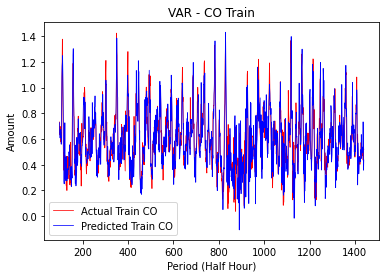

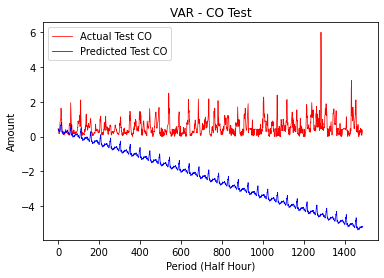

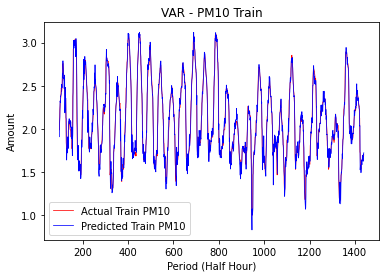

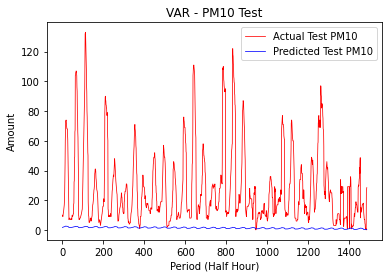

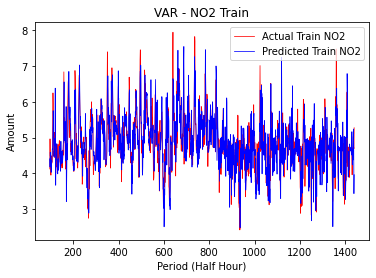

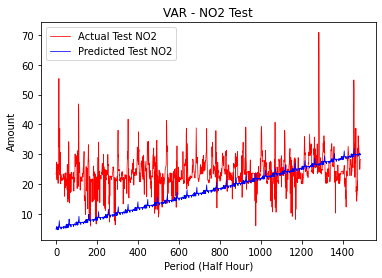

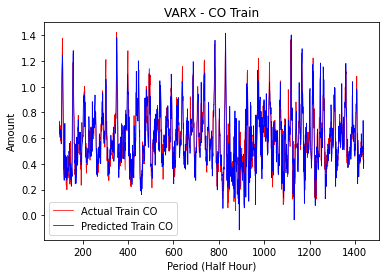

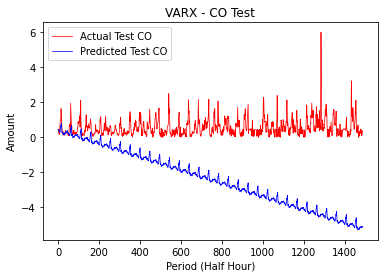

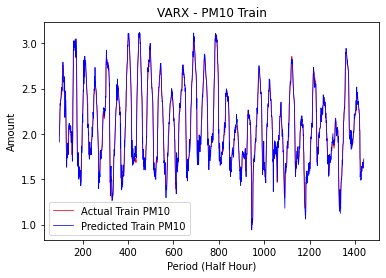

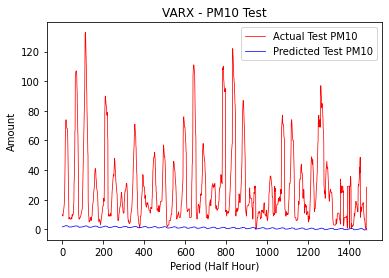

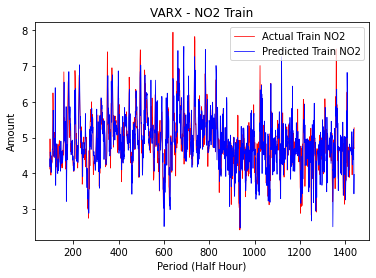

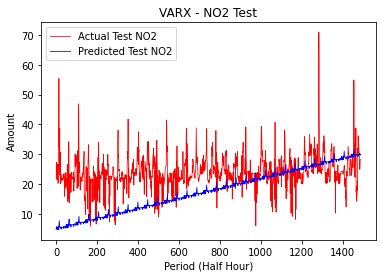

<Figure size 432x288 with 0 Axes>

In [ ]:
############ VAR ############
#CO
plt.plot(datat.CO[97:], color = 'red', label = 'Actual Train CO', linewidth=0.75)
plt.plot(var_train.CO[97:], color = 'blue', label = 'Predicted Train CO', linewidth=0.75)
plt.title('VAR - CO Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/co train/" +str(RMSEv)+ ' VAR - CO Train.png')

plt.plot(data_test.CO, color = 'red', label = 'Actual Test CO', linewidth=0.75)
plt.plot(var_test.CO, color = 'blue', label = 'Predicted Test CO', linewidth=0.75)
plt.title('VAR - CO Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/co test/" +str(RMSEvt)+ ' VAR - CO Test.png')

#PM10
plt.plot(datat.PM10[97:], color = 'red', label = 'Actual Train PM10', linewidth=0.75)
plt.plot(var_train.PM10[97:], color = 'blue', label = 'Predicted Train PM10', linewidth=0.75)
plt.title('VAR - PM10 Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/pm10 train/" +str(RMSEv2)+ ' VAR - PM10 Train.png')

plt.plot(data_test.PM10, color = 'red', label = 'Actual Test PM10', linewidth=0.75)
plt.plot(var_test.PM10, color = 'blue', label = 'Predicted Test PM10', linewidth=0.75)
plt.title('VAR - PM10 Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/pm10 test/" +str(RMSEvt2)+ ' VAR - PM10 Test.png')

#NO2
plt.plot(datat.NO2[97:], color = 'red', label = 'Actual Train NO2', linewidth=0.75)
plt.plot(var_train.NO2[97:], color = 'blue', label = 'Predicted Train NO2', linewidth=0.75)
plt.title('VAR - NO2 Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/no2 train/" +str(RMSEv3)+ ' VAR - NO2 Train.png')

plt.plot(data_test.NO2, color = 'red', label = 'Actual Test NO2', linewidth=0.75)
plt.plot(var_test.NO2, color = 'blue', label = 'Predicted Test NO2', linewidth=0.75)
plt.title('VAR - NO2 Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/no2 test/" +str(RMSEvt3)+ ' VAR - NO2 Test.png')



############ VARX ############
#CO
plt.plot(datat.CO[97:], color = 'red', label = 'Actual Train CO', linewidth=0.75)
plt.plot(varx_train.CO[97:], color = 'blue', label = 'Predicted Train CO', linewidth=0.75)
plt.title('VARX - CO Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/co train/" +str(RMSEvarx)+ ' VARX - CO Train.png')

plt.plot(data_test.CO, color = 'red', label = 'Actual Test CO', linewidth=0.75)
plt.plot(varx_test.CO, color = 'blue', label = 'Predicted Test CO', linewidth=0.75)
plt.title('VARX - CO Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/co test/" +str(RMSEvarxt)+ ' VARX - CO Test.png')

#PM10
plt.plot(datat.PM10[97:], color = 'red', label = 'Actual Train PM10', linewidth=0.75)
plt.plot(varx_train.PM10[97:], color = 'blue', label = 'Predicted Train PM10', linewidth=0.75)
plt.title('VARX - PM10 Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/pm10 train/" +str(RMSEvarx2)+ ' VARX - PM10 Train.png')

plt.plot(data_test.PM10, color = 'red', label = 'Actual Test PM10', linewidth=0.75)
plt.plot(varx_test.PM10, color = 'blue', label = 'Predicted Test PM10', linewidth=0.75)
plt.title('VARX - PM10 Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/pm10 test/" +str(RMSEvarxt2)+ ' VARX - PM10 Test.png')

#NO2
plt.plot(datat.NO2[97:], color = 'red', label = 'Actual Train NO2', linewidth=0.75)
plt.plot(varx_train.NO2[97:], color = 'blue', label = 'Predicted Train NO2', linewidth=0.75)
plt.title('VARX - NO2 Train')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/no2 train/" +str(RMSEvarx3)+ ' VARX - NO2 Train.png')

plt.plot(data_test.NO2, color = 'red', label = 'Actual Test NO2', linewidth=0.75)
plt.plot(varx_test.NO2, color = 'blue', label = 'Predicted Test NO2', linewidth=0.75)
plt.title('VARX - NO2 Test')
plt.xlabel('Period (Half Hour)')
plt.ylabel('Amount')
plt.legend()
plt.show()
plt.savefig("/content/drive/My Drive/TA/no2 test/" +str(RMSEvarxt3)+ ' VARX - NO2 Test.png')